In [1]:
# import all necessary packages
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import keras
from keras.models import Model, load_model

from keras.layers import Input, Dense, merge, Reshape, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D, AveragePooling2D, ZeroPadding2D, Convolution2D
from keras.layers.normalization import BatchNormalization

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import keras.backend as K


Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)


1.3.0
2.0.8


# Define some constants

In [3]:
# define the classes
Classes= ['airplane','angel','apple','baseball_bat','brain','birthday_cake','bear','butterfly','canoe','cello',
          'chair','chandelier','church','diamond','dishwasher','dragon','duck','elephant','fire_hydrant','flamingo',
          'flower','giraffe','guitar','hand','headphones','hurricane','ice_cream','jail','lion','lipstick',
          'map','moon','ocean','owl','pig','police_car','rabbit','rainbow','river','The_Mona_Lisa']

NUM_CLASSES = len(Classes)
print('#Classes', NUM_CLASSES )

IMAGE_PER_CLASS = 12000 #20 images per class
print('#Images per class', IMAGE_PER_CLASS)

CHANNELS = 1
IMG_ROWS, IMG_COLS = 224, 224 

# path to store the pretrain weights
WEIGHTS_PATH = 'imagenet_models/'

# training paramaters
EPOCHS = 10
BATCH_SIZE = 64

NB_FREEZE_LAYER = 30



#Classes 40
#Images per class 12000


# Generating Train and Test Data Set

In [ ]:
# This cell is only if you are loading the data from scratch
# generate data set
def generate_data_set(classes, start_from, num_examples_per_class):
    quickdraws = [np.load("./quickdraw/{}.npy".format(qdraw))[start_from:(start_from+num_examples_per_class)] for qdraw in classes]
    
    # Concat the arrays together
    x_data = np.concatenate(quickdraws,axis=0)
    x_data.shape
    
    filename = 'MyData_'+str(NUM_CLASSES)+'class_'+str(num_examples_per_class)+'sample'+str(start_from)+'.npy'
    np.save(filename,x_data)
    print('File ', filename, ' saved')
    return filename

#Get the Data
train_file = generate_data_set(Classes, 20, IMAGE_PER_CLASS)
test_file = generate_data_set(Classes, 15000, IMAGE_PER_CLASS)

In [4]:
train_file = 'MyData_'+str(NUM_CLASSES)+'class_'+str(IMAGE_PER_CLASS)+'sample20.npy'
test_file = 'MyData_'+str(NUM_CLASSES)+'class_'+str(IMAGE_PER_CLASS)+'sample15000.npy'

#load the training and testing data
image_train_data = np.load(train_file)
image_test_data = np.load(test_file)

print(image_train_data.shape)
print(image_test_data.shape)


(480000, 784)
(480000, 784)


In [5]:
## generate the labels for image
labels = [np.full((IMAGE_PER_CLASS,), Classes.index(qdraw)) for qdraw in Classes]
label_data = np.concatenate(labels,axis=0)

label_train_data = label_data
label_test_data = label_data

print(label_train_data.shape)
print(label_test_data.shape)
#label_data.shape

(480000,)
(480000,)


# Utilities and Pre-processing

In [6]:
def show_object(obj):
    # Reshape 784 array into 28x28 image
    image = obj.reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(image, cmap='gray_r')
    plt.show()

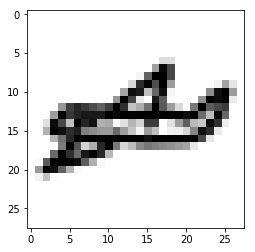

airplane


In [7]:
show_object(image_train_data[25])
print(Classes[label_train_data[25]])

In [8]:
np_utils.to_categorical(label_train_data[25], NUM_CLASSES)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

In [9]:
#shuffling function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

image_train_data,label_train_data = unison_shuffled_copies(image_train_data,label_train_data)
image_test_data,label_test_data = unison_shuffled_copies(image_test_data,label_test_data)


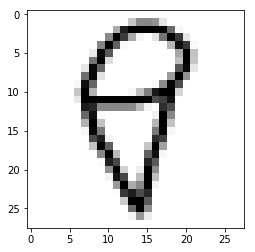

ice_cream


In [10]:
show_object(image_train_data[25])
print(Classes[label_train_data[25]])


In [11]:
# convert label to one hot
label_train_data = np_utils.to_categorical(label_train_data, NUM_CLASSES)
label_test_data = np_utils.to_categorical(label_test_data, NUM_CLASSES)


In [12]:
label_train_data[25]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [72]:
# Expand the 1 channel grayscale to 3 channel grayscale image
image_train_data.shape

temp1 = np.zeros((IMAGE_PER_CLASS*NUM_CLASSES, 28, 28, 3))
temp1[:, :, :, 0:] = image_train_data
temp1[:, :, :, 1:] = image_train_data
temp1[:, :, :, 2:] = image_train_data
temp1.shape

(480000, 28, 28, 3)

In [73]:
show_object(temp1[25,:,:,0])

image_train_data = temp1

KeyboardInterrupt: 

In [ ]:
temp1 = np.zeros((IMAGE_PER_CLASS*NUM_CLASSES, 28, 28, 3))
temp1[:, :, :, 0:] = image_test_data
temp1[:, :, :, 1:] = image_test_data
temp1[:, :, :, 2:] = image_test_data

image_test_data = temp1

In [40]:
# Reshape and normalize image data


image_train_data = image_train_data.reshape(image_train_data.shape[0], 28, 28, 3)
image_test_data = image_test_data.reshape(image_test_data.shape[0], 28, 28, 3)

image_train_data = image_train_data.astype('float32')
image_test_data = image_test_data.astype('float32')


ValueError: cannot reshape array of size 376320000 into shape (480000,28,28,3)

In [14]:
# normalize the image
image_train_data = image_train_data/255
image_test_data = image_test_data/255


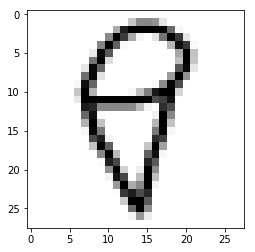

In [15]:
show_object(image_train_data[25]) # should still show same image,

# Define ResNet-50 Model and load pre-train weights

In [16]:
# reference model from François Chollet's github
# https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """
    The identity_block is the block that has no conv layer at shortcut
    Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    """

    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x


In [17]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """
    conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """

    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x


In [20]:
def ResNet50_Model(img_rows, img_cols, channels=1, num_classes=None):

    global bn_axis
    # Handle Dimension Ordering for different backends
    if K.image_dim_ordering() == 'tf':
        #tensorflow
        bn_axis = 3
        img_input = Input(shape=(img_rows, img_cols, channels))
    else:
        #theano
        bn_axis = 1
        img_input = Input(shape=(channels, img_rows, img_cols))


    #define the ResNet-50 Model 
    x = ZeroPadding2D((3, 3))(img_input)
    x = Convolution2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    # Fully Connected Softmax Layer
    x_orifc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_orifc = Flatten()(x_orifc)
    x_orifc = Dense(1000, activation='softmax', name='fc_last')(x_orifc)
    
    # Create model.
    model = Model(img_input, x_orifc, name='resnet50')

    
    # for Tensorflow Backend, download this weight
    # https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5
    
    # for Theano Backend, download this weight
    # https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
    
    # load weights
    if K.backend() == 'tensorflow':
        #tensorflow weights
        weights_path = WEIGHTS_PATH +'resnet50_weights_tf_dim_ordering_tf_kernels.h5'
    else:
        #theano weights
        weights_path = WEIGHTS_PATH +'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

    model.load_weights(weights_path)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_newfc = Flatten()(x_newfc)
    x_newfc = Dense(num_classes, activation='softmax', name='fc10')(x_newfc)
    
    # Create model.
    model = Model(img_input, x_newfc, name='quickdraw_resnet50')
    
    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [38]:
#global bn_axis
# Handle Dimension Ordering for different backends
bn_axis = 3
img_input = Input(shape=(28, 28, 3))

#define the ResNet-50 Model 
x = ZeroPadding2D((3, 3))(img_input)
x = Convolution2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

# Fully Connected Softmax Layer
x_orifc = AveragePooling2D((7, 7), name='avg_pool')(x)
x_orifc = Flatten()(x_orifc)
x_orifc = Dense(1000, activation='softmax', name='fc_last')(x_orifc)

# Create model.
model = Model(img_input, x_orifc, name='resnet50')




/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), name="res2a_branch2a", strides=(1, 1))`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="res2a_branch2b", padding="same")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res2a_branch2c")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res2a_branch1", strides=(1, 1))`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/gc/anac

/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2048, (1, 1), name="res5a_branch1", strides=(2, 2))`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (1, 1), name="res5b_branch2a")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), name="res5b_branch2b", padding="same")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2048, (1, 1), name="res5b_branch2c")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (1, 1), name="res5c_branch2a")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarni

ValueError: Negative dimension size caused by subtracting 7 from 1 for 'avg_pool_5/AvgPool' (op: 'AvgPool') with input shapes: [?,1,1,2048].

In [39]:
# load weights
weights_path = WEIGHTS_PATH +'resnet50_weights_tf_dim_ordering_tf_kernels.h5'
model.load_weights(weights_path)

In [ ]:



# Truncate and replace softmax layer for transfer learning
# Cannot use model.layers.pop() since model is not of Sequential() type
# The method below works since pre-trained weights are stored in layers but not in the model
x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
x_newfc = Flatten()(x_newfc)
x_newfc = Dense(NUM_CLASSES, activation='softmax', name='fc10')(x_newfc)
    
# Create model.
model = Model(img_input, x_newfc)

# Learning rate is changed to 0.001
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Generator for training loop

In [21]:
train_img_gen = ImageDataGenerator()
test_img_gen = ImageDataGenerator()

train_generator = train_img_gen.flow(image_train_data, label_train_data, batch_size=BATCH_SIZE)
test_generator = test_img_gen.flow(image_test_data, label_test_data, batch_size=BATCH_SIZE)

# Callbacks

In [22]:
from keras.callbacks import ModelCheckpoint

#Callback to save after each epoch
checkpoint_filepath="./checkpoint_TransferLearning-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True)

callbacks_list = [checkpointer]


# Training loop

In [23]:
# transfer learning from ResNet50
model = ResNet50_Model(IMG_ROWS, IMG_COLS, CHANNELS, NUM_CLASSES)
model.summary()


/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), name="res2a_branch2a", strides=(1, 1))`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="res2a_branch2b", padding="same")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res2a_branch2c")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res2a_branch1", strides=(1, 1))`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/gc/anac

/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (1, 1), name="res5b_branch2a")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), name="res5b_branch2b", padding="same")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2048, (1, 1), name="res5b_branch2c")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (1, 1), name="res5c_branch2a")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), name="res5c_branch2b", padding="same")`
/home/gc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarni

ValueError: Dimension 0 in both shapes must be equal, but are 7 and 64 for 'Assign' (op: 'Assign') with input shapes: [7,7,1,64], [64,3,7,7].

In [ ]:
#train the model
hist = model.fit_generator(train_generator,
                           epochs=EPOCHS,
                           steps_per_epoch=(IMAGE_PER_CLASS*NUM_CLASSES/BATCH_SIZE),
                           verbose=1,
                           max_queue_size=20,
                           validation_data=test_generator,
                           validation_steps=20,
                           callbacks=callbacks_list,
                           freeze_layers_number= NB_FREEZE_LAYER)

model.save('Quickdraw_TransferLearning.hdf5')

# central cropping

# reflection